# Model Fitting in Python: Scipy, SciKit-Learn, and Emcee

This is a tutorial on scientific Python for the [KIPAC computing boot camp](http://kipac.github.io/BootCamp).

Authors: [Sean McLaughlin](http://github.com/mclaughlin6464), [Joe Derose](http://github.com/j-dr)

Model fitting is one of the most common and important things researchers have to do. There is not a one-size-fits-all solution to all model fitting problems, however. For example:
* Perhaps we need to a fit a relatively simple model to a large dataset (or a large number of smaller datasets) and we want the fit to be efficient
* Maybe we don't know what kind of model we need so we want to be able to easily compare a suite of models
* Perhaps the model fit is our entire analyis, and we need to understand all uncertainties and correlations very well

We will look at Python packages that handle different situations like these.

First though, we'll need some data to fit! We'll generate two datasets, a simple linear dataset and a slightly more complex nonlinear model. 

In [1]:
from __future__ import print_function, division # if you don't have Python 3

In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
true_m, true_b = 0.68, 2.38
N = 100
x = np.linspace(0,50,N)

def linear_func(x, m=true_m, b=true_b):
    return m*x+b

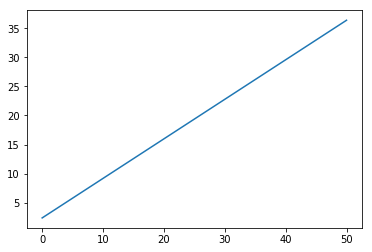

In [4]:
true_linear_y = linear_func(x)
plt.plot(x, true_linear_y)
plt.show()

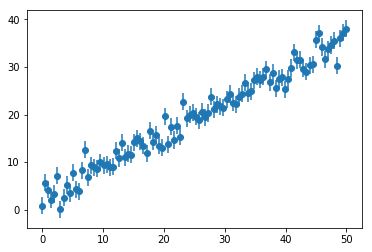

In [5]:
# add noise
sigma = 1.8
obs_linear_y = true_linear_y+ np.random.randn(N)*sigma
plt.errorbar(x, obs_linear_y, yerr = np.ones(N)*sigma,marker='o', ls='None')
plt.show()

In [6]:
true_p1, true_p2, true_p3, true_p4, true_p5 = -2.1, 0.8, -0.021, 4.3, 0.6
true_nonlinear_params = np.array([true_p1, true_p2, true_p3, true_p4, true_p5])
def nonlinear_func(x,p1=true_p1,p2=true_p2,p3=true_p3,p4=true_p4,p5=true_p5):
    # define a complex nonlinear function to fit
    return p1+p2*x+p3*x*x+p4*np.sin(x*p5)

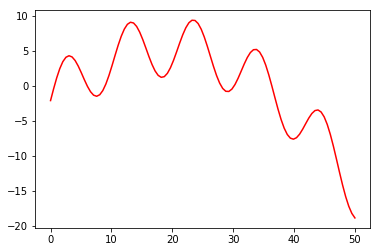

In [7]:
true_nonlinear_y = nonlinear_func(x)
plt.plot(x, true_nonlinear_y, color = 'r')

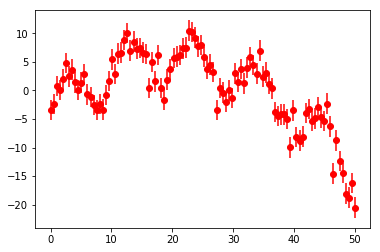

In [8]:
# add noise
obs_nonlinear_y = true_nonlinear_y+ np.random.randn(N)*sigma
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o', ls='None', color = 'r')
plt.show()

## Scipy
----
NumPy contains much of the functionality required to perform efficient operations in python, but you will soon realize that there is not a great deal of high level functionality implemented in numpy. 

[Scipy](http://docs.scipy.org/doc/scipy/reference/) is the module where you *will* find a great deal of high level functionality that is very useful for day to day scientific computing. 

Some of the very useful submodules that can be found in SciPy are:

* [Linear Algebra](http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html)
* [Statistics](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
* [Integration](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
* [Interpolation](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)
* [FFT](http://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html)
* [Optimization](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

Today we be delving into some of the details of Linear Algebra and Optimization, but keep in mind that you will find similar depth in these other applications

We'll start with a simple linear system. Scipy has a great many useful linear algebra functions, including inverses, determinants, and eigenvalues! We can showcase some of these with a dummy matrix. 

In [9]:
A = np.eye(4)
A[1,2] = 3 # just to keep it interesting
print(A)

[[1. 0. 0. 0.]
 [0. 1. 3. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [10]:
from scipy.linalg import inv, det, eigvals

In [12]:
print(inv(A), det(A), eigvals(A))

[[ 1.  0.  0. -0.]
 [ 0.  1. -3. -0.]
 [ 0.  0.  1. -0.]
 [ 0.  0.  0.  1.]] 1.0 [1.+0.j 1.+0.j 1.+0.j 1.+0.j]


We will focus on the linear least squares solver in scipy. Recall that linear least squares finds the solution $\hat{x}$ to the system

$$ \mathbf{A}x = \mathbf{b} $$ 

that minimizes the squared absolute error. 

$$ \left\lVert \mathbf{A}x - b \right \rVert^2 $$

In the special case that your data satisfies the [Gauss-Markov Theroem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) (which ours do) the linear least squares solution will give the optimal unbiased estimator $\hat{x}$. Let's try it out on our linear model. 

In [14]:
from scipy.stats import linregress
from scipy.linalg import lstsq

fit_m, fit_b, r,p, std_err = linregress(x, obs_linear_y)
print('R^2 = ',r**2)
print('Fit:', fit_m, fit_b)
print('Truth:', true_m, true_b)

R^2 =  0.9643732541077874
Fit: 0.6676119354750584 2.6041480432876973
Truth: 0.68 2.38


The standard error is not an estimate of the error on the data points; it is used for estimating uncertanties in parameter estimates. To estimate sigma one can use this formula ( I found on Wikipedia)! 

In [15]:
print(np.sqrt(np.sum((obs_linear_y - linear_func(x, fit_m, fit_b))**2)/(N)))

1.870734100223024


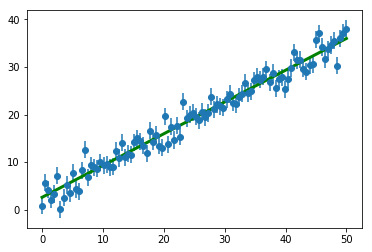

In [16]:
plt.errorbar(x, obs_linear_y, yerr = np.ones(N)*sigma,marker='o', ls='None')
plt.plot(x, fit_m*x+fit_b, color = 'g', lw = 3)
plt.show()

I actually used `scipy.stats`'s `linregress` module here instead of `lstsq`. That will give us the same answer, but with a few extra steps.  

In [17]:
A = np.ones((N,2))
A[:,1] = x #build a design matrix

(fit_b2, fit_m2), _,_,_ = lstsq(A, obs_linear_y)
print(fit_m2, fit_b2)

0.6676119354750584 2.604148043287698


Why the extra steps? Well, that's because **linear least squares is not just for fitting lines**! Any linear model can be fit with linear least squares. Let's try that for our next excercise! 

### Exercise 1
Use linear least squares to fit to our nonlinear model. You'll have to assume that we know `true_p5` perfectly; all other parameters are linear. You'll have to start by making a design matrix, which will be similar to the matrix A above.  

---

Linear least squares works well for linear problems (which is not just lines!) But of course this is not all problems. Indeed, even for Excercise 1, we had to assume we knew a nonlinear parameter. How would we go about fitting for parameters like these? 

This is in general a much harder than linear optimization. If you have a consistent solution that works in all cases let me know and maybe we can share a Fields medal!

We will focus on two techniques that are commonly used in scipy: `curve_fit` (which uses [nonlinear least squares](http://mathworld.wolfram.com/NonlinearLeastSquaresFitting.html) )and `minimize` (which uses a variety of gradient descent-esque methods). 

In [20]:
from scipy.optimize import curve_fit, minimize

We'll start with [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which has an easy to use interface. To use curve fit, we'll have to a define a function (which we've already done) and give an initial guess. 

In [21]:
initial_guess = np.array([-1, 1, 0, 3, 0.4])
popt, pcov = curve_fit(nonlinear_func, x, obs_nonlinear_y, p0=initial_guess)
print(popt)
print(true_nonlinear_params)

[-2.26726572  0.82272522 -0.02175344 -0.36292456  0.38512492]
[-2.1    0.8   -0.021  4.3    0.6  ]


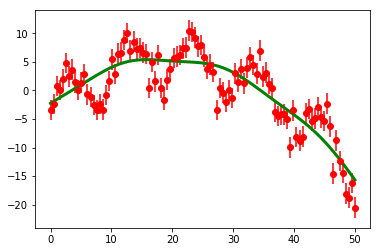

In [22]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *popt), color = 'g', lw = 3)
plt.show()

Hm, this did ok, but not great. This is hard! In general you may want to try several guesses if you're unsatisfied. In this case, since we know the truth, we can make an unreasonably good guess. We can also add some uncertainty information that we have. 

In [23]:
initial_guess = np.array([-2, 1, 0, 4, 0.55])
popt, pcov = curve_fit(nonlinear_func, x, obs_nonlinear_y, p0=initial_guess, sigma=np.ones(N)*sigma)
print(popt)
print(true_nonlinear_params)

[-3.31270843  0.88257223 -0.02238935  4.21663743  0.60244086]
[-2.1    0.8   -0.021  4.3    0.6  ]


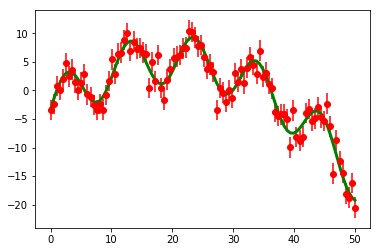

In [24]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *popt), color = 'g', lw = 3)
plt.show()

We also got a covariance matrix from the estimator. Let's use it now to calculates some uncertanties on our params.

In [25]:
errors = np.sqrt(np.diag(pcov))
for i,(p, e) in enumerate(zip(popt, errors)):
    print('Param {} = {} +/-{}'.format(i+1,p,e))

Param 1 = -3.31270843092 +/-0.507753072177
Param 2 = 0.882572231247 +/-0.0469940594904
Param 3 = -0.0223893511187 +/-0.000912511094732
Param 4 = 4.2166374292 +/-0.243225790859
Param 5 = 0.602440862347 +/-0.00207005066848


Let's move onto [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Minimize has a bit of a different use case; it seeks to minimize a function, rather than find a best fit. However, if we phrase our problem as a minimization, we can use it! Minimize supports several different optimization algorithms, depending on the nature of the problem. If you have access to bounds, constraints, or jacobian/hessians, you should use a function that exploits them. For now, we'll focus on the more basic ones. 

We'll begin by designing a **loss function**, which represents the loss that we want to minimize. We'll return to these again when we discuss MCMC. 

In [26]:
def loss_function(params, func, y_data, x_data):
    # just stick with a simple least squares
    return np.sum((y_data - func(x_data, *params))**2)

In [27]:
initial_guess = np.array([-1, 1, 0, 3, 0.4])
res = minimize(loss_function, initial_guess, args = (nonlinear_func, obs_nonlinear_y, x))

Minimze returns an object with results. We'll check if it thinks it was successful and see what the best guess was.

In [28]:
print(res.success)
print(res.x)
print(true_nonlinear_params)

False
[-2.26692674  0.82268948 -0.02175277 -0.36294415  0.38513048]
[-2.1    0.8   -0.021  4.3    0.6  ]


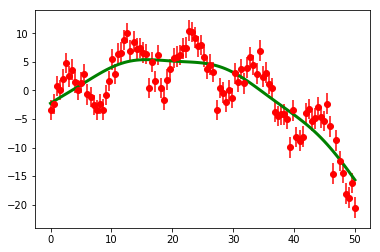

In [29]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *res.x), color = 'g', lw = 3)
plt.show()

Damn. No luck. 

There's a lot of ways we could proceed here. Why don't we try it as an excercise? 

### Exercise 2
Find a good fit to the nonlinear data using minimize. You may want to try using a different method, or perhaps doing something fancy with your loss function (for example, regularizing). 

## Sklearn 
---
[scikit-learn](http://scikit-learn.org/stable/) is a massive and very powerful library for machine learning and data analysis. Like with `scipy` we will delve into the details of one module (Regression) to get a taste of what it holds. 

The most powerful feature of sklearn is not just the function contained within, but the way they are designed. Almost all objects in sklearn use the same API design. This means you can easily test several different models in the same notebook! I'll import a few more or less random series of methods and make fits with them. 

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

In [31]:
model = LinearRegression()
#model = GaussianProcessRegressor(alpha = sigma, normalize_y=True)
#model = RandomForestRegressor(n_estimators = 10)
#model = KernelRidge(kernel='rbf')

A = np.c_[np.ones(N), x]
model.fit(A,obs_linear_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

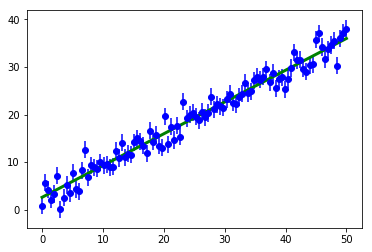

In [32]:
plt.errorbar(x, obs_linear_y, yerr = np.ones(N)*sigma,marker='o',color='b', ls='None')
plt.plot(x, model.predict(A), color = 'g', lw = 3)
plt.show()

Try rerunning the above two cells by commenting out different models. How does the prediction change?

---

Obviously, for such a large suite of models, we need a reliable way to decide which one to use! One place to start is by looking at various quantitative scores. Things like R^2 or Mean Square Error give an idea of which model is a better fit, better than "eyeballing" it. 

In [33]:
#R^2 score
model.score(A, obs_linear_y)

0.9643732541077871

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(obs_linear_y, model.predict(A))

3.4996460737372472

However, it's obvious that this is not ideal; in many cases the model that fits "better" is overfit! Is there anyway we can see if our fit generalizes? 

We can use cross validation, which sklearn also supports. There are functions for generating separate test and validation sets easily. We'll use `cross_val_score`, which does this behind the scenes and calculates the goodness of fit. 

In [35]:
from sklearn.model_selection import cross_val_score
print(-1*cross_val_score(model, A, obs_linear_y, cv = 10, scoring='neg_mean_squared_error'))

[5.90762557 5.02806152 1.436795   2.85608795 5.64702495 1.08142006
 1.17082287 3.77395233 3.82217598 5.32212888]


This is only the beginning of such features. Some of our models above have *hyperparameters* which also need to be optimized. We won't explore any functions for that here, but needless to say sklearn has helper functions for that as well. 

## Exercise 3
Repeat the above process for the nonlinear data. What model works best?

## MCMC and Emcee
----
In some types of problems, we care about more than just the "best fit" to a model. In cosmology especially, the distribution of what parameters are likely is more important. What are the likely values of a parameter? Are they degenerate/correlated? These are the kind of questions that Bayesian Analysis (and specifically, MCMC) can answer.

This is an extremely in depth-topic that can barely be covered here. However, I hope that we can scratch the surface of why this is something you'll consider using in your analysis. For a great tutorial on these topics in a similar format, read [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). 

Let's say that we want to understand the distribution of some parameters $\theta$ given some data $x$. Bayes' theorem states that the following is true:

$$ P(\theta | x) = \frac{P(\theta)\;P(x | \theta)}{P(x)} $$

Let's attach a little vocab to the terms here. $P(\theta | x)$, what we're after, is known as the *posterior*. $P(\theta)$ is known as the *prior* and represents our prior knowledge (if any) about the parameters in our model. $P(x | \theta)$ is the *likelihood* of the data given the parameters. Finally, $P(x)$ is known as the *evidence*. In general, the evidence is difficult to compute. Fortunately, we usually don't need to calculate it, as it serves only as a normalization constant. Therefore, we can refer to the posterior as

$$ P(\theta|x) \propto P(\theta)\;P(x|\theta) $$

There's a few things we'll want to do with the posterior. Firstly, we'll want to draw samples from it. The density of these samples will be proportional to the posterior distribution, if we use MCMC. Additionally, we may want to integrate over some parameters. Perhaps there are some parameters we just don't care about. A good example is sigma, which we've presumed we've known up til now, but in many real cases we don't know well. We'll want to integrate over those, which will incorporate any uncertantiy in those parameters into our final distribution. We also want to know the expectation values of individual parameters after integrating over all the others (wheter we care about them or not). MCMC enables us to do all of this! 

We'll be using [emcee](http://dfm.io/emcee/current/) which is an MCMC sampler written by astonomer. If you don't have it already, it can be installed with `pip install emcee`. Let's start by fitting to our linear model. We'll have to build a few basic things to hand to the emcee sampler, so let's start there. We'll need:
* A prior over our parameters
* A liklihood for the parameters given our data
* Some hyperparameters for the sampler that determine its sampling scheme
* An initial guess

In [36]:
def lnprior(theta):
    b,m,sigma = theta
    if sigma < 0:
        return -np.inf
    return 0#1/(sigma*np.sqrt(1+m**2)**3)

This is an uniformative prior on all our parameters. For a justification, read [this post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) about it. For what it's worth, in this problem a flat prior in both parameters would probably be fine. note that since many of liklihoods we'll be dealing with are so small, 
the prior and the liklihood are actually the lnprior, lnlikelihood.
Additionally, since we only care about proportional liklihoods and priors,we can be lazy about the normalization.

In [37]:
def lnlike(theta, x, y):
    b,m,sigma = theta
    y_pred = linear_func(x,m,b)
    return -np.sum(2*np.log(sigma) + ((y - y_pred)/sigma)**2)

args = (x, obs_linear_y)

This is just the log of a Gaussian, but with a few terms that won't change the final product because of their proportionality. Now, let's take care of the rest of the bookkeeping and run the sampler.

In [38]:
def lnprob(theta, *args):
    p = lnprior(theta)
    if not np.isfinite(p):
        return -np.inf
    return p+lnlike(theta, *args)

ndim = 3
nwalkers = 100
nsteps = 1100
nburn = 100

#Create a sampler with 100 walkers, each who take 1100 steps, of which
# we will toss the first 100 (the "burn in")
initial_guess = np.zeros((nwalkers, ndim))
for i in xrange(nwalkers):
    initial_guess[i,0] = np.random.rand()*20-10 #U(-10,10)
    initial_guess[i,1] = np.random.randn()*2+1  #N(1, 2)
    initial_guess[i,2] = np.random.rand()*5     #U(0,5)

In [39]:
#now let's go
import emcee as mc
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=args)

In [40]:
sampler.reset()
sampler.run_mcmc(initial_guess, nsteps);

Now, the sampler object has a chain attached to it. We can take a look and see the paths the walkers took.

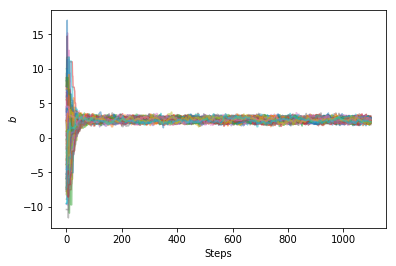

In [41]:
for w in xrange(nwalkers):
    plt.plot(sampler.chain[w,:,0], alpha = 0.5)

plt.ylabel(r'$b$')
plt.xlabel('Steps')
plt.show()

Looks converged! In a real analysis you'd want to do a more nuanced analysis of the convergence of the chains, by taking a look at convergence statistics or something like that. For now, we'll trust our gut. Let's look at the posteriors of these parameters. We'll use the handy tool [ChainConsumer](https://samreay.github.io/ChainConsumer/chain_api.html). 

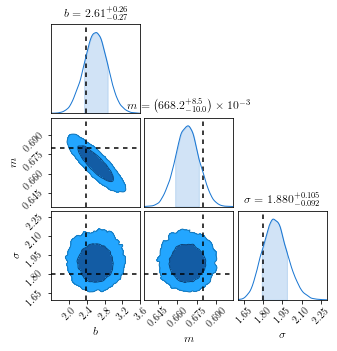

In [43]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(sampler.chain[:,nburn:,:].reshape((-1, ndim))\
            , parameters = [r'$b$',r'$m$', r'$\sigma$'],
            walkers=nwalkers)
fig = c.plotter.plot(truth = [true_b, true_m, sigma])
plt.show()

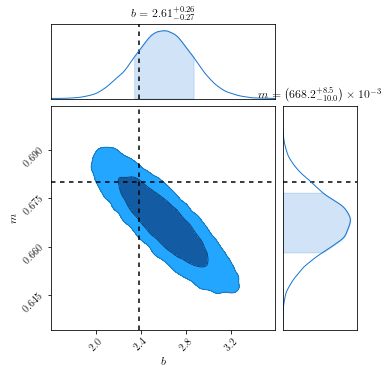

In [44]:
#look at only the non-nuisance parameters (marginalize out uncertainty)
fig = c.plotter.plot(figsize=(5,5),parameters = [r'$b$', r'$m$'],\
                     truth = [true_b, true_m])
plt.show()

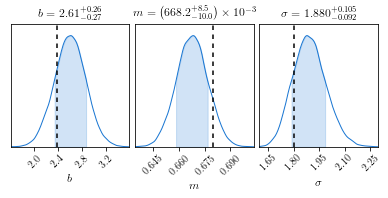

In [45]:
c.plotter.plot_distributions(truth=[true_b, true_m, sigma]);

In [54]:
#We can look at some convergence statistics
c.diagnostic.gelman_rubin()

Gelman-Rubin Statistic values for chain 0
$b$: 1.02021 (Passed)
$m$: 1.02133 (Passed)
$\sigma$: 1.02026 (Passed)


True

Our results are a bit biased, but we've made fewer assumptions then above. We now also have a more complete understanding of the details of our model! 

## Exercise 4
You probably know the drill by now. Can you perform a similar fit to our nonlinear model? This will be more complex then anything we've done so far; but the results will be interesting! 

### Solutions
---

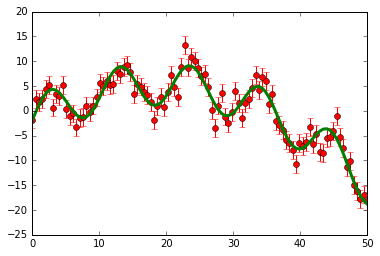

In [16]:
#Exercise 1
A = np.ones((N,4))
A[:,1] = x
A[:,2] = x**2
A[:,3] = np.sin(true_p5*x)

(fit_p1, fit_p2, fit_p3, fit_p4), _,_,_ = lstsq(A, obs_nonlinear_y)

plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, fit_p1, fit_p2, fit_p3, fit_p4), color = 'g', lw = 3)
plt.show()

---

[-1.95869754  0.77651366 -0.02063072  4.2456252   0.59786143]


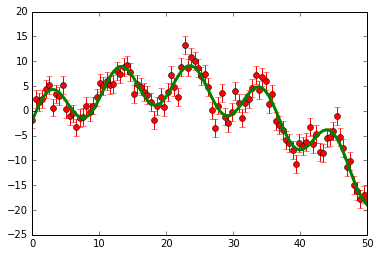

In [27]:
#Exercise 2
# I found that Powell gave a good fit
initial_guess = np.array([-1, 1, 0, 3, 0.4])
res = minimize(loss_function, initial_guess,method='Powell', args = (nonlinear_func, obs_nonlinear_y, x))
print(res.x)
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *res.x), color = 'g', lw = 3)
plt.show()

[-1.94392219  0.77426485 -0.02057512  4.24253158  0.59856627]


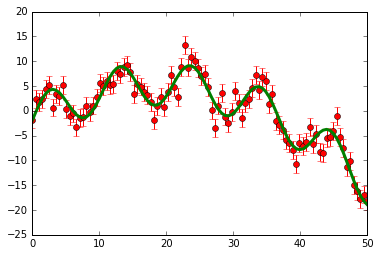

In [28]:
#alternatively, one could try regularizing the last parameter, as it seems to dominate this fit. 
# Weirdly, I find it fits the data well despite not being "right"
def loss_function2(params, func, y_data, x_data, l=-1e3):
    # add in a l1 regularization
    return np.sum((y_data - func(x_data, *params))**2)+l*params[-1]

res = minimize(loss_function2, initial_guess, args = (nonlinear_func, obs_nonlinear_y, x))
print(res.x)
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *res.x), color = 'g', lw = 3)
plt.show()

----

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.378518530559
[  41.36574614   56.12201277   17.26953218    3.28761806   70.51376139
   16.68945734   47.9713164    15.37490071    6.41791552  113.42155251]


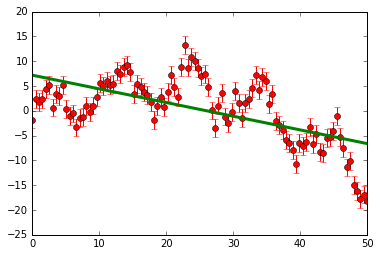

GaussianProcessRegressor(alpha=1.8, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)
0.864020265716
[  10.90754137    3.46715846   47.61533739    6.03655367   67.61326796
    9.48454992   19.04946318   31.81474727   41.08806365  212.12690456]


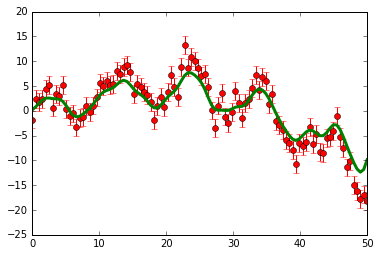

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.975475932643
[ 10.84866282  28.71803983  15.29114381  16.0851484   19.96575383
  34.60621971  16.76889005  24.61712707   7.26138355  87.26255464]


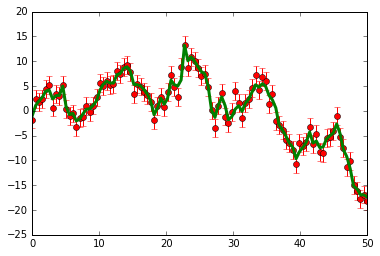

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
0.916549591506
[  10.83833384    3.24262253   41.3229107     5.74089972   57.92271692
    9.00474577   18.04176036   23.94130677   30.95932437  171.9096728 ]


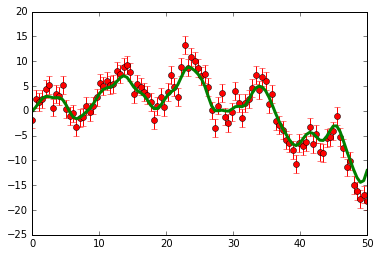

In [44]:
#Exercise 3
# Feel free to throw in other estimators! 
from sklearn.metrics import r2_score
for m, hp in zip([LinearRegression, GaussianProcessRegressor, RandomForestRegressor, KernelRidge],\
                 [{},{'alpha':sigma, 'normalize_y':True}, {'n_estimators':10}, {'kernel':'rbf'}]):
    model = m(**hp)
    print(model)    
    A = np.c_[np.ones(N), x]
    model.fit(A,obs_nonlinear_y)
    plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
    plt.plot(x, model.predict(A), color = 'g', lw = 3)
    print(r2_score(obs_nonlinear_y,model.predict(A)))
    print(-1*cross_val_score(model, A, obs_nonlinear_y, cv = 10, scoring='neg_mean_squared_error'))
    plt.show()

In [ ]:
# Exercise 4
#I haven't worked this out yet! I leave it as an exercise to the reader :). 